# init

In [1]:
import sys 
sys.path.append('pyfiles/')
import classes_loop as cl
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 
import csv 

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

points = cl.ellipse_example(numpts = 6)
# note: 100 pts causes handling error

# first complex

In [2]:
init_complex = cl.initcomplex(points)
s_complex = cl.complex()
s_complex.key_point = (2,-0.5)

# update this to .self so don't need input, except maybe key pt
distlist = s_complex.find_sq_dist(init_complex)
cl.sort_complex(s_complex, distlist, plot = False)

# this is the permutation
all_simplices = s_complex.order_all_simps()
# I am pretty sure the simps are also ordered in s_complex, 
# not just all_simplices.
mat = cl.bdmatrix()
# assign simplices to matrix columns
mat.make_matrix(s_complex)
# reduce the matrix
mat.redmatrix = mat.reduce(display = False)
# this adds in a column for reduced homology
mat.add_dummy_col()
# find the (r,c) vales of lowest ones in the matrix, 
# and also identify zero columns
mat.find_lows_zeros(all_simplices, output = True)

betti_dummy, betti_zero, betti_one = mat.find_bettis()
mat.find_bd_pairs(output = True)
print("\nbetti dummy: ", betti_dummy, 
      "\nbetti zero: ", betti_zero, 
      "\nbetti one:" ,betti_one)

Zero Columns:
col : [0, 2, 3, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 1]
col_index : [-1, 1, 0, 4, 2, 3, 3]

Lowest Ones:
col : [1, 4, 5, 7, 9, 11]
row : [0, 3, 2, 6, 8, 10]
dim : [-1, 0, 0, 0, 0, 0]
col_index : [5, 0, 5, 4, 1, 2]
row_index : [-1, 0, 1, 4, 2, 3]
simplices labeled by initial val, not column:

emptyset-1 birthed a -1dim h class killed by v5
v0 birthed a 0dim h class killed by e0
v1 birthed a 0dim h class killed by e5
v4 birthed a 0dim h class killed by e4
v2 birthed a 0dim h class killed by e1
v3 birthed a 0dim h class killed by e2
e3 birthed an inf 1dim h class

betti dummy:  0 
betti zero:  0 
betti one: 1


# second complex

In [3]:
init2_complex = cl.initcomplex(points)
second_complex = cl.complex()
second_complex.key_point = (2,0.5)

# update this to .self so don't need input, except maybe key pt
distlist2 = second_complex.find_sq_dist(init2_complex)
cl.sort_complex(second_complex, distlist2, plot = False)

# this is the permutation
all_simplices2 = second_complex.order_all_simps()
# I am pretty sure the simps are also ordered in s_complex, 
# not just all_simplices.
mat2 = cl.bdmatrix()
# assign simplices to matrix columns
mat2.make_matrix(second_complex)
# reduce the matrix
mat2.redmatrix = mat2.reduce(display = False)
# this adds in a column for reduced homology
mat2.add_dummy_col()
# find the (r,c) vales of lowest ones in the matrix, 
# and also identify zero columns
mat2.find_lows_zeros(all_simplices2, output = True)

betti_dummy2, betti_zero2, betti_one2 = mat2.find_bettis()
mat2.find_bd_pairs(output = True)
print("\nbetti dummy: ", betti_dummy2, 
      "\nbetti zero: ", betti_zero2, 
      "\nbetti one:" ,betti_one2)

Zero Columns:
col : [0, 2, 3, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 1]
col_index : [-1, 5, 0, 2, 4, 3, 3]

Lowest Ones:
col : [1, 4, 5, 7, 9, 11]
row : [0, 3, 2, 6, 8, 10]
dim : [-1, 0, 0, 0, 0, 0]
col_index : [1, 0, 5, 1, 4, 2]
row_index : [-1, 0, 5, 2, 4, 3]
simplices labeled by initial val, not column:

emptyset-1 birthed a -1dim h class killed by v1
v0 birthed a 0dim h class killed by e0
v5 birthed a 0dim h class killed by e5
v2 birthed a 0dim h class killed by e1
v4 birthed a 0dim h class killed by e4
v3 birthed a 0dim h class killed by e2
e3 birthed an inf 1dim h class

betti dummy:  0 
betti zero:  0 
betti one: 1


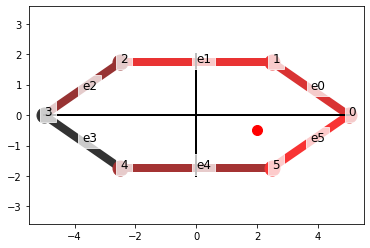

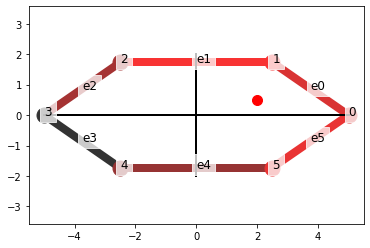

In [4]:
s_complex.plot(extras = False, label_edges = True)
second_complex.plot(extras = False, label_edges = True)

# maybe instead of lexicographical ordering on edges, 
# maybe use min entrance value of vertices to break tie

In [13]:
vin = cl.vineyard()
# re init these just to make sure we can run this multiple times
vin.pointset = np.empty(2)
vin.complexlist = []
vin.matrixlist = []
vin.keypointlist = []
vin.add_complex(cl.ellipse_example(numpts = 6, display = False),(2,0.5))
vin.add_complex(cl.ellipse_example(numpts = 6, display = False),(2,-0.5))

Zero Columns:
col : [0, 2, 3, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 1]
col_index : [-1, 5, 0, 2, 4, 3, 3]

Lowest Ones:
col : [1, 4, 5, 7, 9, 11]
row : [0, 3, 2, 6, 8, 10]
dim : [-1, 0, 0, 0, 0, 0]
col_index : [1, 0, 5, 1, 4, 2]
row_index : [-1, 0, 5, 2, 4, 3]
simplices labeled by initial val, not column:

emptyset-1 birthed a -1dim h class killed by v1
v0 birthed a 0dim h class killed by e0
v5 birthed a 0dim h class killed by e5
v2 birthed a 0dim h class killed by e1
v4 birthed a 0dim h class killed by e4
v3 birthed a 0dim h class killed by e2
e3 birthed an inf 1dim h class

betti dummy:  0 
betti zero:  0 
betti one: 1
Zero Columns:
col : [0, 2, 3, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 1]
col_index : [-1, 1, 0, 4, 2, 3, 3]

Lowest Ones:
col : [1, 4, 5, 7, 9, 11]
row : [0, 3, 2, 6, 8, 10]
dim : [-1, 0, 0, 0, 0, 0]
col_index : [5, 0, 5, 4, 1, 2]
row_index : [-1, 0, 1, 4, 2, 3]
simplices labeled by initial val, not column:

emptyset-1 birthed a -1dim h class killed by v5
v0 birthed 

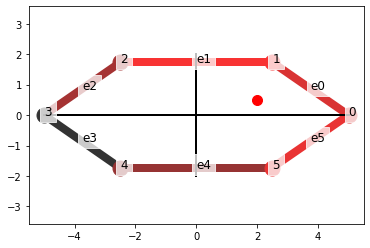

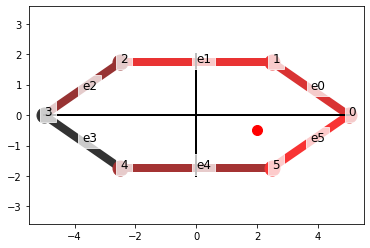

In [11]:
vin.complexlist[0].plot(extras = False, label_edges = True)
vin.complexlist[1].plot(extras = False, label_edges = True)

# ToDo: 
- would be cool: replot the graph, but labeling mothers and murderers
- also cool: make graph into an animation that shows whole process
- separate voroni MA from example and add it as a graph option
- be able to tell if multiple interchanges happened
- if so, be able to find new special point and recompute things
- be able to tell if interchange was type changing (maybe should think about this first, because if multiple non type changing interchanges happen, maybe we don't actually care about them, and don't need to move special point)